In [ ]:
!pip install vanna
import vanna
from vanna.remote import VannaDefault
vn = VannaDefault(model='chinook', api_key=vanna.get_api_key('my-email@example.com'))
vn.connect_to_sqlite('https://vanna.ai/Chinook.sqlite')
vn.ask("What are the top 10 albums by sales?")

In [ ]:
from vanna.flask import VannaFlaskApp
VannaFlaskApp(vn).run()

## Here's what you'll get
![vanna-flask](https://vanna.ai/blog/img/vanna-flask.gif)

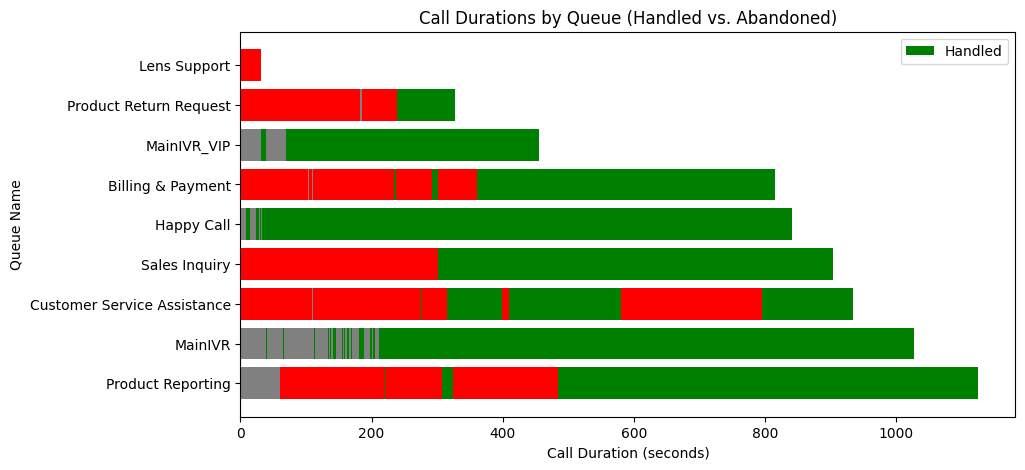

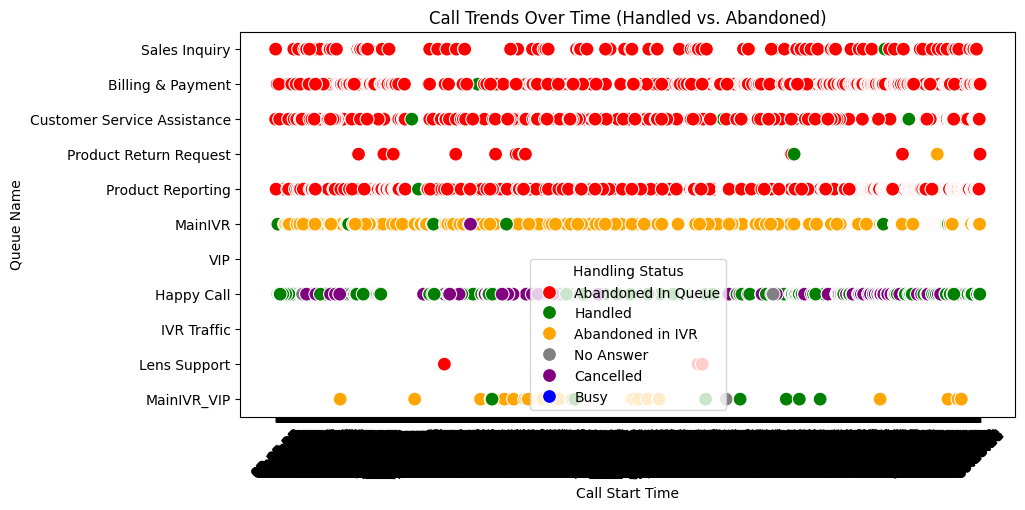

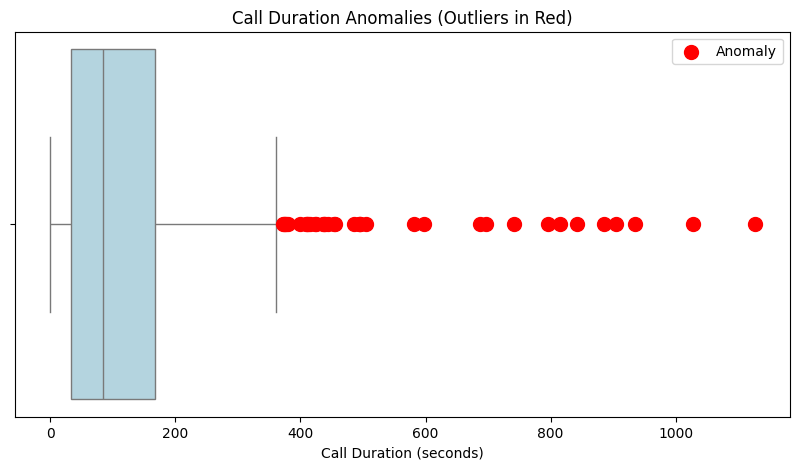

Anomaly report saved as anomaly_report.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_calls(csv_file):
    # Load dataset
    df = pd.read_csv(csv_file)

    # Convert timestamps to datetime
    df["start_time"] = pd.to_datetime(df["start_time_stamp"], errors='coerce')
    df["end_time"] = pd.to_datetime(df["end_time_stamp"], errors='coerce')

    # Calculate call durations in seconds
    df["duration_sec"] = (df["end_time"] - df["start_time"]).dt.total_seconds()

    # Anomaly detection using IQR
    Q1 = df["duration_sec"].quantile(0.25)
    Q3 = df["duration_sec"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df["is_anomaly"] = (df["duration_sec"] < lower_bound) | (df["duration_sec"] > upper_bound)

    # Plot Call Durations
    plt.figure(figsize=(10, 5))
    df_sorted = df.sort_values(by="duration_sec", ascending=False)
    colors = df_sorted["handling_status_name"].apply(lambda x: "green" if x == "Handled" else "red" if x == "Abandoned In Queue" else "gray")
    plt.barh(df_sorted["queue_name"], df_sorted["duration_sec"], color=colors)
    plt.xlabel("Call Duration (seconds)")
    plt.ylabel("Queue Name")
    plt.title("Call Durations by Queue (Handled vs. Abandoned)")
    plt.legend(["Handled", "Abandoned"], loc="upper right")
    plt.show()

    # Plot Call Trends Over Time
    plt.figure(figsize=(10, 5))
    df["call_time"] = df["start_time"].dt.strftime('%H:%M:%S')
    sns.scatterplot(
        x=df["call_time"],
        y=df["queue_name"],
        hue=df["handling_status_name"],
        palette={"Handled": "green", "Abandoned In Queue": "red","Abandoned in IVR": "orange","Cancelled": "purple","Busy": "blue","No Answer": "gray"},
        s=100
    )
    plt.xlabel("Call Start Time")
    plt.ylabel("Queue Name")
    plt.title("Call Trends Over Time (Handled vs. Abandoned)")
    plt.xticks(rotation=45)
    plt.legend(title="Handling Status")
    plt.show()

    # Boxplot for Call Durations with Anomalies
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df["duration_sec"], showfliers=False, color="lightblue")
    anomalies = df[df["is_anomaly"]]
    plt.scatter(anomalies["duration_sec"], [0] * len(anomalies), color="red", label="Anomaly", zorder=3, s=100)
    plt.xlabel("Call Duration (seconds)")
    plt.title("Call Duration Anomalies (Outliers in Red)")
    plt.legend()
    plt.show()

    # Save anomaly report
    anomaly_report = df[df["is_anomaly"]][["queue_name", "handling_status_name", "start_time", "duration_sec"]]
    anomaly_report.to_csv("anomaly_report.csv", index=False)
    print("Anomaly report saved as anomaly_report.csv")

# Example usage:
analyze_calls("coway.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_abandoned_trends(csv_file):
    # Load dataset
    df = pd.read_csv(csv_file)

    # Convert start_time_stamp to datetime
    df["start_date"] = pd.to_datetime(df["start_time_stamp"], errors='coerce').dt.date

    # Filter for only 'Abandoned In Queue'
    abandoned_df = df[df["handling_status_name"] == "Abandoned In Queue"]

    # Count occurrences per date per service queue
    trend_data = abandoned_df.groupby(["start_date", "queue_name"]).size().reset_index(name="count")

    # Plot trends
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=trend_data, x="start_date", y="count", hue="queue_name", marker="o")
    plt.xlabel("Date")
    plt.ylabel("Number of Abandoned Calls")
    plt.title("Trend of Abandoned In Queue Calls by Service")
    plt.xticks(rotation=45)
    plt.legend(title="Queue Name")
    plt.grid()
    plt.show()

    print("Trend analysis completed!")

# Example usage:
plot_abandoned_trends("coway.csv")
